In [36]:
# Append the parent directory to the path
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

# Import base packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import pickle
from tqdm import tqdm

# Make the graphs pretty
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 10, 'font.style': 'normal', 'font.family':'serif'})

In [37]:
# Import custom classes and functions
from environments.base import BaseEnvironment, SimpleBilateralEnvironment
from environments.contextual import ContextualEnvironment, OrderBookEnvironment 
from learners.bandits import ConquerAndDivide

In [60]:
d = 8
T = 1000000

X = np.random.rand(T, d)
A = (np.random.rand(d, 2) - 0.5) * 2
L = np.max(np.sum(np.abs(A), axis=0))

Y = X@A
min_Y = np.min(Y)
max_Y = np.max(Y)
Y = (Y-min_Y)/(max_Y-min_Y)
L = L/(max_Y-min_Y)
print(L)
print(Y.shape)

mask = Y[:, 0] > Y[:, 1]
Y[mask] = Y[mask][:, ::-1]

0.7885561335865162
(1000000, 2)


In [65]:
def algo_run(d, T, L):
    order_book, valuation_sequence = X[:T, :d], Y[:T]
    env = OrderBookEnvironment(T, order_book, valuation_sequence)
    algo = ConquerAndDivide(T, d, L, env)
    algo.run()
    regret = env.get_policy_gft_having_adhoc_valuations() - algo.get_final_gft()
    return regret

In [ ]:
combos = {}
for d in [2, 4, 8]:
    for T in [10**5 + i*10**4 for i in range(11)]:
        regrets = Parallel(n_jobs=-1)(
            delayed(algo_run)(d, T, L) for _ in range(100)
        )
        combos[(d, T)] = np.array(regrets)

In [ ]:
# with open('../data/combos1.pkl', 'wb') as f:
#     pickle.dump(combos, f)

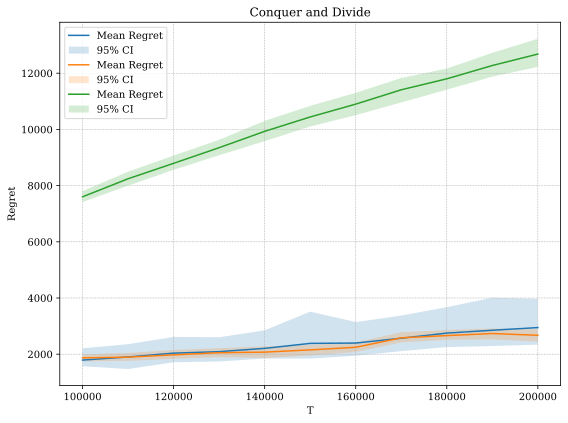

In [74]:
plt.figure(figsize=(8, 6))

for d in [2, 4, 8]:
    Ts = [10**5 + i*10**4 for i in range(11)]
    regrets_matrix = np.array([combos[(d, T)] for T in Ts])
    
    mean_regret = regrets_matrix.mean(axis=1)
    percentile_2_5 = np.percentile(regrets_matrix, 2.5, axis=1)
    percentile_97_5 = np.percentile(regrets_matrix, 97.5, axis=1)
    
    plt.plot(Ts, mean_regret, label='Mean Regret')
    plt.fill_between(Ts, percentile_2_5, percentile_97_5, alpha=0.2, label='95% CI')
    
    
plt.grid(True, which="both", ls="--", lw=0.5)
plt.xlabel("T")
plt.ylabel("Regret")
plt.title("Conquer and Divide")
plt.legend()
plt.tight_layout()
plt.show()

## SPY order book

In [23]:
from pathlib import Path
import pandas as pd

df = pd.read_csv(str(Path.cwd().parent) + "/data/03272019.PSX_ITCH50_SPY_book_5.csv")
df.head()

,time,1_bid_price,1_bid_vol,1_ask_price,1_ask_vol,2_bid_price,2_bid_vol,2_ask_price,2_ask_vol,3_bid_price,...,3_ask_price,3_ask_vol,4_bid_price,4_bid_vol,4_ask_price,4_ask_vol,5_bid_price,5_bid_vol,5_ask_price,5_ask_vol
0,28800013717272,NaN,NaN,280.69,5000.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28800013772985,280.62,5000.0,280.69,5000.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,28800023809983,280.62,5000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,28800023919299,280.64,5000.0,NaN,NaN,280.62,5000.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,28800023941767,280.64,5000.0,NaN,NaN,280.63,5000.0,NaN,NaN,280.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df.isna().mean()

time           0.000000
1_bid_price    0.000367
1_bid_vol      0.000367
1_ask_price    0.000106
1_ask_vol      0.000106
2_bid_price    0.001182
2_bid_vol      0.001182
2_ask_price    0.000477
2_ask_vol      0.000477
3_bid_price    0.002325
3_bid_vol      0.002325
3_ask_price    0.001232
3_ask_vol      0.001232
4_bid_price    0.003344
4_bid_vol      0.003344
4_ask_price    0.002306
4_ask_vol      0.002306
5_bid_price    0.004228
5_bid_vol      0.004228
5_ask_price    0.003469
5_ask_vol      0.003469
dtype: float64

In [25]:
df = df.bfill().ffill() # fill missing values

In [26]:
df.columns

Index(['time', '1_bid_price', '1_bid_vol', '1_ask_price', '1_ask_vol',
       '2_bid_price', '2_bid_vol', '2_ask_price', '2_ask_vol', '3_bid_price',
       '3_bid_vol', '3_ask_price', '3_ask_vol', '4_bid_price', '4_bid_vol',
       '4_ask_price', '4_ask_vol', '5_bid_price', '5_bid_vol', '5_ask_price',
       '5_ask_vol'],
      dtype='object')

In [27]:
df = df.drop(columns="time")

In [32]:
# Scale vol columns
volume_cols = [col for col in df.columns if 'vol' in col]
max_val = df[volume_cols].values.max()
df[volume_cols] = df[volume_cols] / max_val

# Scale price columns
price_cols = [col for col in df.columns if 'price' in col]
price_min = df[price_cols].values.min()
price_max = df[price_cols].values.max()
df[price_cols] = (df[price_cols] - price_min) / (price_max - price_min)

In [39]:
T, d = df.shape

X = df.values
A = (np.random.rand(d, 2) - 0.5) * 2
L = np.max(np.sum(np.abs(A), axis=0))

Y = X@A
min_Y = np.min(Y)
max_Y = np.max(Y)
Y = (Y-min_Y)/(max_Y-min_Y)
L = L/(max_Y-min_Y)
print(L)
print(Y.shape)

mask = Y[:, 0] > Y[:, 1]
Y[mask] = Y[mask][:, ::-1]

2.6565018907745905
(993770, 2)


In [40]:
def algo_run(d, T, L):
    order_book, valuation_sequence = X[:T, :d], Y[:T]
    env = OrderBookEnvironment(T, order_book, valuation_sequence)
    algo = ConquerAndDivide(T, d, L, env)
    algo.run()
    regret = env.get_policy_gft_having_adhoc_valuations() - algo.get_final_gft()
    return regret

In [41]:
combos = {}
for T in [int(T/10*i) for i in range(11)]:
    regrets = Parallel(n_jobs=-1)(
        delayed(algo_run)(d, T, L) for _ in range(32)
    )
    combos[(d, T)] = np.array(regrets)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 993770/993770 [00:10<00:00, 95314.95it/s] 


In [ ]:
# with open('../data/combos2.pkl', 'wb') as f:
#     pickle.dump(combos, f)

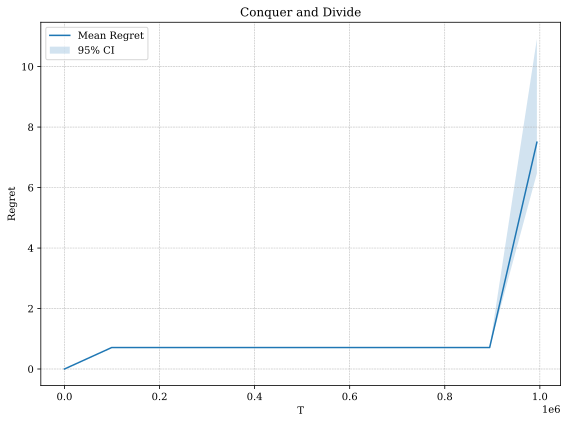

In [43]:
plt.figure(figsize=(8, 6))

Ts = [int(T/10*i) for i in range(11)]
regrets_matrix = np.array([combos[(d, T)] for T in Ts])

mean_regret = regrets_matrix.mean(axis=1)
percentile_2_5 = np.percentile(regrets_matrix, 2.5, axis=1)
percentile_97_5 = np.percentile(regrets_matrix, 97.5, axis=1)

plt.plot(Ts, mean_regret, label='Mean Regret')
plt.fill_between(Ts, percentile_2_5, percentile_97_5, alpha=0.2, label='95% CI')
    
    
plt.grid(True, which="both", ls="--", lw=0.5)
plt.xlabel("T")
plt.ylabel("Regret")
plt.title("Conquer and Divide")
plt.legend()
plt.tight_layout()
plt.show()